# Práctica 2: clasificación de dígitos MNIST mediante AdaBoost

**Introducción**

Importar librerías

In [935]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from keras.datasets import mnist

Desde la libería de Keras podemos descargar la base datos MNIST

In [936]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [937]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

Guardar base de datos en un fichero

In [938]:
np.savez("mnist",x=x_train,y=y_train)

Cargar base de datos desde un fichero

In [939]:
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']
mnist_X.shape

(60000, 28, 28)

Mostrar una imagen de MNIST

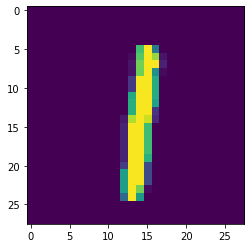

Etiqueta: 1


In [940]:
plt.figure()
plt.imshow(x_train[40])
plt.show()
print("Etiqueta: " + str(y_train[40]))

**Implementación AdaBoost**

Adaptación de los arrays de imágenes y etiquetas para AdaBoost:
Lo que hacemos es cambiar la forma de la matriz X, para que sea un simple vector de 60000x784, utilizando reshape()

In [941]:
def adaptar_conjuntos(X, Y):
    X = mnist_X.reshape(60000,28*28)
    Y = mnist_Y
    return (X,Y)
(X,Y) = adaptar_conjuntos(mnist_X, mnist_Y)

Funcion para especificar la clase que utilizaremos:
En este caso modificamos el vector Y, para que en caso de que el valor de Y[i] corresponda al valor de la clase, este elemento cuente como un '1', en caso contrario sera '-1'

In [942]:
def clase(Y,clase):
    Ytemp = np.full(len(Y),0)
    for i in range(len(Y)):
        if Y[i]==clase:
            Ytemp[i]= 1
        else:
            Ytemp[i]= -1
    #print(Ytemp)
    return Ytemp

Funciones necesarias para los clasificadores débiles

In [943]:
# Dimensión con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil(dimension_datos):
    pixel = random.randint(0,dimension_datos-1)
    umbral = random.randint(0,255) 
    booleano_dir = random.randint(0,1)

    if booleano_dir == 0:
        direccion = -1
    else:
        direccion = 1

    return (pixel,umbral,direccion) # Devolvemos el clasificador debil generado

In [944]:
def aplicar_clasificador_debil(clasificador, imagen):
    pixel = clasificador[0]
    umbral = clasificador[1]
    direccion = clasificador[2]

    if direccion == 1:
        if imagen[pixel] >= umbral:
            res = True
        else:
            res = False
    else:
        
        if imagen[pixel] < umbral:
            
            res = True
        else:
            res = False

    return res

In [945]:
def obtener_error(clasificador, X, Y, D):
    error = 0.0

    for i in range(len(X)):
        if aplicar_clasificador_debil(clasificador,X[i]):
            if Y[i] != 1:
                error = error + D[i]
        else:
            if Y[i] == 1:
                error = error + D[i]

    return error

Funcion de entrenamiento para un clasificador fuerte:

In [946]:
def entrenar(X, Y, T, A):
    clasificadores_debiles = []
    alfas = []
    D = np.full(len(X), 1/len(X))
    tam_img = 28*28

    for t in range(T):

        min_cd=((),2)

        for k in range(A):

            cd = generar_clasificador_debil(tam_img)
            error = obtener_error(cd,X,Y,D)

            if error < min_cd[1] or min_cd[1] == 2:
                min_cd=(cd,error)

        clasificadores_debiles.append(min_cd[0])

        if min_cd[1]<=0:
            alfa=1/2
        else:
            alfa = (1/2) * math.log( (1-min_cd[1])/min_cd[1] ,2)


        alfas.append(alfa)

        Z=np.sum(D)
        Dtemp=np.copy(D)

        for x in range(len(X)):
            if aplicar_clasificador_debil(min_cd[0],X[x]):
                cd_d=1
            else:
                cd_d=-1
            
            Dtemp[x]=D[x]*np.exp(-alfa*Y[x]*cd_d)

        D = Dtemp/Z
            
    return (clasificadores_debiles, alfas)

Funcion para aplicar un clasificador fuerte a un conjunto de imagenes:

In [947]:
def aplicarCF(H,X):
    res=np.full(len(X),0.0)

    for x in range(len(X)):
        h=0.0
        for i in range(len(H[0])):
            cd_res=aplicar_clasificador_debil(H[0][i],X[x])
            if cd_res:
                cd_res=1
            else:
                cd_res=-1

            h += H[1][i]*cd_res
        res[x]=h

    res = np.sign(res)
    res = res.astype(int)
    return res

Análisis y resultados de las pruebas realizadas 

Las siguientes 2 funciones se utilizan para obtener tanto el numero de aciertos como el porcentaje de aciertos, la parte comentada puede ser util para depurar y ver los resultados exactos.

In [948]:
def comparar(res,Y):
    aciertos=0
    for y in range(len(Y)):
        if res[y]==Y[y]:
            aciertos+=1

    return round(aciertos/len(Y)*100,2)

In [949]:
def resultados(cf_img,Y,tam_muestra):
    print('lenY:',len(Y))
    aciertos = 0.0
    aciertosC = np.full(10,0.0)
    fallos = 0.0
    fallosC = np.full(10,0.0)
    for i in range(tam_muestra):
        for j in range(10):
            if cf_img[i][j] == 1 and Y[i]==j:
                aciertos+=1
                aciertosC[j]+=1
            elif Y[i]!=j and cf_img[i][j] == 1:
                fallos+=1
                fallosC[j]+=1
    print('Aciertos Total:',aciertos)
    print('Fallos Total:',fallos)

    for j in range(10):
        count = sum(map(lambda x : x==j,Y[:tam_muestra]))
        print('Clase:',j,' Aciertos:',aciertosC[j],' Fallos:',fallosC[j],' img(',j,'):',count,' Porcentaje de aciertos:',round(aciertosC[j]/count*100,2),'%','Porcentaje de fallos:',round(fallosC[j]/tam_muestra*100,2))
    print('Imagenes = ',tam_muestra,' | A = ',A,' | T = ',T,' | Porcentaje de aciertos(Total) = ',round(aciertos/tam_muestra*100,2),'%','Porcentaje de fallos(Total) = ',round(fallos/tam_muestra*100,2))

Para dividir el conjunto de entrenamiento y test, lo que se ha hecho es utilizar las primeras N imagenes del vector X para el entrenamiento, luego para realizar las pruebas se utiliza el rango N*(p-1)+ hasta N*p, donde p es el numero de la prueba actual, en el codigo siguiente se puede ver como se utiliza:

Para utilizar el conjunto de prueba tenemos la siguiente funcion:


In [950]:
def pruebas(Hlista,Y,tam_muestra):

    P = 10 #Num de pruebas
    for p in range(2,P):
        muestra_hasta = tam_muestra*p
        muestra_desde = tam_muestra*(p-1)+1
        if(muestra_hasta > 60000):
            muestra_hasta=60000
            
        for c in range(10):
            Yclase = clase(Y,c)

            Xtest = X[muestra_desde:muestra_hasta]
            Ytest = Yclase[muestra_desde:muestra_hasta]

            resTest = aplicarCF(Hlista[c],Xtest)
            porcentajeTest = comparar(resTest,Ytest)

            for i in range(tam_muestra-1):
                cf_img[i][c] = resTest[i]
                #print('c=',c,'resTest[i]=',resTest[i],' cf_img[i][c]=',cf_img[i][c],' Y[i]=',Y[i],' Ytest[i]=',Ytest[i])

            print('clase: ',c,' resultados test[',muestra_desde,'-',muestra_hasta,']: ',porcentajeTest)
        
        if(muestra_hasta==60000):
            break

        print('Resultados de prueba para: |',muestra_desde,' - ',muestra_hasta,'|:')
        Yr = Y[muestra_desde:muestra_hasta]
        print('desde:',muestra_desde,'hasta:',muestra_hasta)
        resultados(cf_img,Yr,len(Yr))

A continuacion se encuentra el codigo principal, donde declaramos nuestros parametros T,A, y el tam_muestra (cantidad de imagenes a utilizar para entrenar y por prueba), ademas en esta parte del codigo llamamos al entrenamiento para cada clase(0-9), y guardamos los clasificadores fuertes(H) en una lista (Hlista)

In [951]:
T = 100 #num cd a usar
A = 1000 #num pruebas aleatorias para cada cd
tam_muestra=1000
cf_img = np.full((tam_muestra,10),[0])
Hlista = []
for c in range(10):
    Yclase = clase(Y,c)

    Xtrain=X[:tam_muestra]
    Ytrain=Yclase[:tam_muestra]

    H = entrenar(Xtrain, Ytrain, T, A)
    Hlista.append(H)
    print('Entrenado')
    res = aplicarCF(H,Xtrain)

    for i in range(tam_muestra):
        cf_img[i][c] = res[i]
        print('c=',c,'res[i]=',res[i],' cf_img[i][c]=',cf_img[i][c],' Y[i]=',Y[i],' Ytrain[i]=',Ytrain[i])

    porcentajeEntrenamiento = comparar(res,Ytrain)

    print('clase: ',c,' (T:',T,' A:',A,') resultados train[',tam_muestra,']: ',porcentajeEntrenamiento,'%')
print('len:',len(Hlista),' Hlista:',Hlista)
print('Resultados de entrenamiento:')
resultados(cf_img,Y,tam_muestra)

pruebas(Hlista,Y,tam_muestra)



Entrenado
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 5  Ytrain[i]= -1
c= 0 res[i]= 1  cf_img[i][c]= 1  Y[i]= 0  Ytrain[i]= 1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 4  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 1  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 9  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 2  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 1  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 3  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 1  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 4  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 3  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 5  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 3  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 6  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 1  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 7  Ytrain[i]= -1
c= 0 res[i]= -1  cf_img[i][c]= -1  Y[i]= 2  Ytrain[i]= -1
c= 0 re

Y a continuacion obtendremos graficas comparativas a partir de resultados obtenidos en ejecuciones anteriores:

In [952]:
# Para A = 10
# T = [0, 50, 100, 150, 200, 250]      # Numero de clasificadores 
# resultados = [0, 20, 35, 56, 68] # Resultados obtenidos de clasificacion

# plt.title("Porcentajes con valores de T (A=10)")
# plt.plot(T, resultados)
# plt.show()

# Para A = 100
# T = [0, 50, 100, 150, 200, 250]      # Numero de clasificadores 
# resultados = [0, 20, 35, 56, 68] # Resultados obtenidos de clasificacion

# plt.title("Porcentajes con valores de T (A=100)")
# plt.plot(T, resultados)
# plt.show()

# Para A = 200
# T = [0, 50, 100, 150, 200, 250]      # Numero de clasificadores 
# resultados = [0, 20, 35, 56, 68] # Resultados obtenidos de clasificacion

# plt.title("Porcentajes con valores de T (A=200)")
# plt.plot(T, resultados)
# plt.show()

# Para A = 500
# T = [0, 50, 100, 150, 200, 250]      # Numero de clasificadores 
# resultados = [0, 20, 35, 56, 68] # Resultados obtenidos de clasificacion

# plt.title("Porcentajes con valores de T (A=500)")
# plt.plot(T, resultados)
# plt.show()

# Para A = 1000
# T = [0, 50, 100, 150, 200, 250]      # Numero de clasificadores 
# resultados = [0, 20, 35, 56, 68] # Resultados obtenidos de clasificacion

# plt.title("Porcentajes con valores de T (A=1000)")
# plt.plot(T, resultados)
# plt.show()

